In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_excel('JKH.xlsx', 'Sheet1')

#print the head
df.head()

,COMPANY_ID,Date,OPEN_PRICE,PRICE_HI,PRICE_LO,CLOSE_PRICE,TRADE_VOLUME,SHARE_VOLUME,TURNOVER
0,JKH,2016-01-04,179.0,179.0,177.0,177.2,59,285322,50709765.8
1,JKH,2016-01-05,177.4,177.5,176.5,176.8,54,10581,1870881.4
2,JKH,2016-01-06,177.0,177.5,176.0,176.1,94,133449,23556098.7
3,JKH,2016-01-07,176.0,176.0,171.0,173.0,171,949036,162677780.9
4,JKH,2016-01-08,173.0,173.1,172.0,172.2,83,20249,3491700.2


In [2]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'CLOSE_PRICE'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['CLOSE_PRICE'][i] = data['CLOSE_PRICE'][i]

In [4]:
#create features
from fastai.tabular  import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [5]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0
        
#split into train and validation
train = new_data[:650]
valid = new_data[650:]

x_train = train.drop('CLOSE_PRICE', axis=1)
y_train = train['CLOSE_PRICE']
x_valid = valid.drop('CLOSE_PRICE', axis=1)
y_valid = valid['CLOSE_PRICE']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [6]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


15.159388471291626


C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


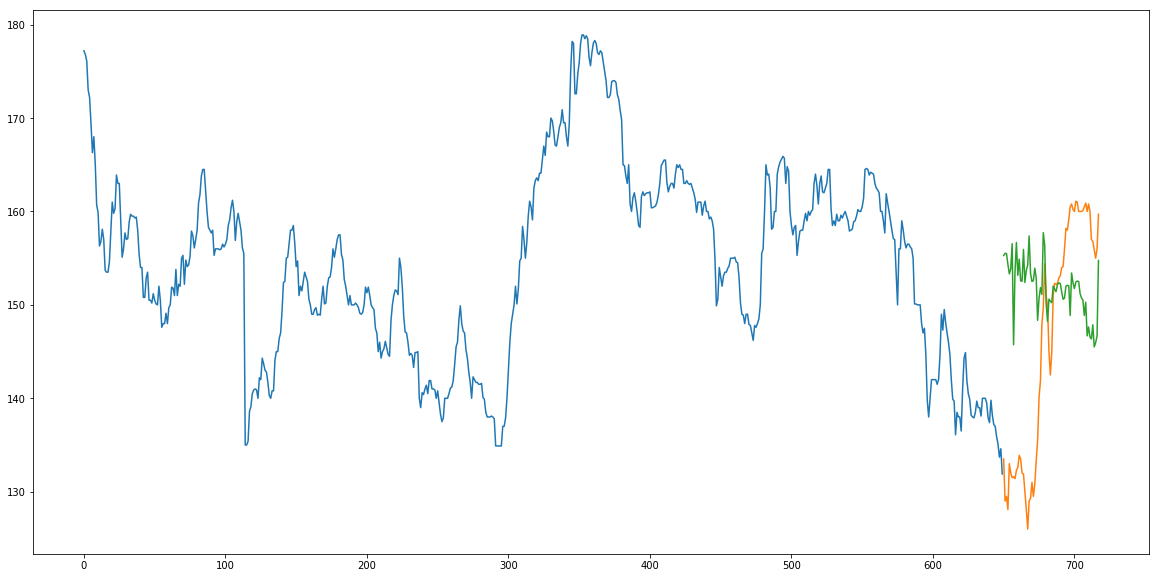

In [9]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms
print(rms)

#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.figure(figsize=(20,10))
plt.plot(train['CLOSE_PRICE'])
plt.plot(valid[['CLOSE_PRICE', 'Predictions']])